In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import json

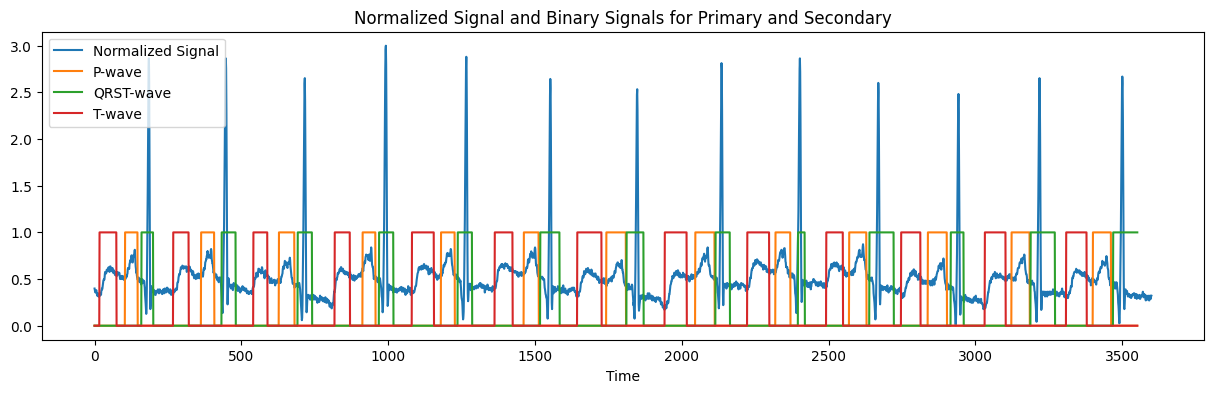

In [2]:
da = pd.read_csv('/media/fathur/F62B-EC7A/BIsmillah/ECGCSVMLII1NSR/1.csv', delimiter=';')
dat = da['data']

# Load the label data
file_path = '/media/fathur/F62B-EC7A/BIsmillah/ecg_folder/1.csv'
with open(file_path, 'r') as file:
    data = json.load(file)

valid_entries = [entry for entry in data if entry["end"] is not None]

if valid_entries:
    max_end = max(entry["end"] for entry in valid_entries)
else:
    max_end = 0

signal_values_p = np.zeros(max_end + 1)
signal_values_qrst = np.zeros(max_end + 1)
signal_values_t = np.zeros(max_end + 1)

for entry in valid_entries:
    start = entry["start"]
    end = entry["end"]
    label = entry["timeserieslabels"][0]
    if label == "P-wave":
        signal_values_p[start:end + 1] = 1
    elif label == "QRS-wave":
        signal_values_qrst[start:end + 1] = 1
    elif label == "T-wave":
        signal_values_t[start:end + 1] = 1

normalized_dat = (dat - np.min(dat)) / (np.max(dat) - np.min(dat)) * 3


plt.figure(figsize=(15, 4))
plt.plot(normalized_dat, label='Normalized Signal')
plt.plot(signal_values_p , label='P-wave')
plt.plot(signal_values_qrst, label='QRST-wave')
plt.plot(signal_values_t, label='T-wave')
plt.xlabel('Time')
plt.title('Normalized Signal and Binary Signals for Primary and Secondary')
plt.legend()
plt.show()


In [3]:
X = np.array(normalized_dat[:3500]).reshape(1,3500)
y = np.array(signal_values_qrst[:3500]).reshape(1,3500)
X=torch.tensor(X, dtype=torch.float32) 
y=torch.tensor(y, dtype=torch.long)

# Hyperparameters
seq_length = 1
num_sequences = 1
batch_size = 32
num_epochs = 100
learning_rate = 0.001


print(X.shape)
print(y.shape)
# DataLoader
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the model
class ConvBiLSTM(nn.Module):
    def __init__(self):
        super(ConvBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.bilstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, 2)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Reshape for LSTM: (batch, seq, feature)
        x, _ = self.bilstm(x)
        x = self.fc(x)
        return x


torch.Size([1, 3500])
torch.Size([1, 3500])


In [ ]:
# Initialize model, loss function, and optimizer
model = ConvBiLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        output = model(batch_X)
        output = output.permute(0, 2, 1)  # Reshape for loss: (batch, feature, seq)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
torch.save(model.state_dict(), '/media/fathur/F62B-EC7A/BIsmillah/model_ecg/segment_qrswave.pth')


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


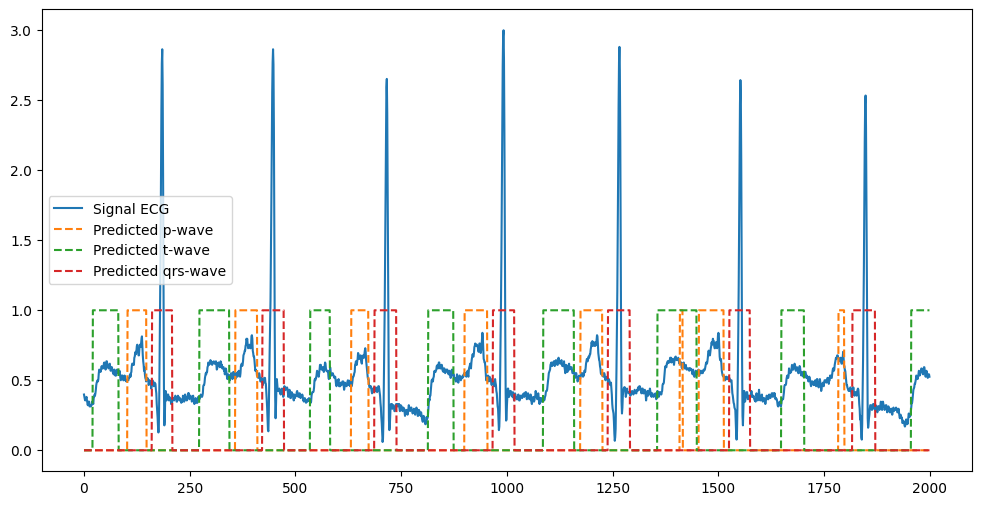

In [4]:
def load_model(model_path):
    model = ConvBiLSTM()  
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model1 = load_model('/media/fathur/F62B-EC7A/BIsmillah/model_ecg/segment_pwave.pth')
model2 = load_model('/media/fathur/F62B-EC7A/BIsmillah/model_ecg/segment_twave.pth')
model3 = load_model('/media/fathur/F62B-EC7A/BIsmillah/model_ecg/segment_qrswave.pth')

with torch.no_grad():
    output1 = model1(X)
    output2 = model2(X)
    output3 = model3(X)
    pred1 = torch.argmax(output1, dim=2)
    pred2 = torch.argmax(output2, dim=2)
    pred3 = torch.argmax(output3, dim=2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(X.flatten()[:2000], label='Signal ECG')
plt.plot(pred1.flatten()[:2000], label='Predicted p-wave', linestyle='--')
plt.plot(pred2.flatten()[:2000], label='Predicted t-wave', linestyle='--')
plt.plot(pred3.flatten()[:2000], label='Predicted qrs-wave', linestyle='--')
plt.legend()
plt.show()